In [1]:
%matplotlib inline
from math import exp,log
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import sys

def add_scalar(x,num):
    if len(num) == 1:
        for i in range(len(x)):
            x[i] += num[0]
    else:
        for i in range(len(x)):
            x[i] += num[i]
    return x

def mult_scalar(x,num):
    if len(num) == 1:
        for i in range(len(x)):
            x[i] *= num[0]
    else:
        for i in range(len(x)):
            x[i] *= num[i]
    return x

def substract_list(x,y):
    aux = []
    for i in range(len(x)):
        aux.append(x[i] - y[i])
    return aux

def obtain_elem(l,ind):
    aux = []
    for i in ind:
        aux.append(l[i-1])
    return aux

def ceil(num):
    if num-int(num) == 0:
        return int(num)
    else:
        return int(num+1)

def percentile(x,p):
    x = list(x)
    aux = p[::]
    x.sort()
    trim = add_scalar(mult_scalar(aux, [(len(x)-1)*0.01]), [1])
    delta = substract_list(trim, map(int, trim))
    return add_scalar(mult_scalar(obtain_elem(x, map(int,trim)), delta) , mult_scalar(obtain_elem(x, map(ceil,trim)), substract_list([1]*len(delta),delta)))

def weighting_years(alpha, horizon_time): # BUM function
    weights = []
    for t in range(horizon_time):
        weights.append((exp(alpha*t/horizon_time)-exp(alpha*(t-1)/horizon_time))/(exp(alpha)-1))
    return weights

def format(matrix):
    new_dict = {}
    for t in range(T):
        if t not in new_dict:
            new_dict[t] = []
        for a in range(n_att):
            new_dict[t].append(tuple(matrix[t][a]))
    return new_dict

def decision_normalization(decision):
    normal = {}
    for t in range(T):
        if t not in normal:
            normal[t] = []
        for a in range(n_att):
            normal[t].append(list(decision[t][a]))
            for x in range(n_resources):
                if attributes[a] == "benefit":
                    normal[t][a][x] = round(decision[t][a][x]/max(decision[t][a]),4)
                else:
                    normal[t][a][x] = round(min(decision[t][a])/(decision[t][a][x]+1e-9),4)
    return normal

def linguistic_values(DD,n_vl):
    D = list(DD)
    delta = 100/(n_vl -1)
    p = range(0,101,delta)
    prc = []
    for i in range(n_att):
        prc.append(percentile(D[i],p))
    LV = []
    for i in range(n_att):
        LV.append([])
        LV[-1].append([prc[i][0],prc[i][0],prc[i][1]])
        for j in range(linguistic_var_number-2):
            LV[-1].append(prc[i][j:j+3])
        LV[-1].append([prc[i][linguistic_var_number-2],prc[i][linguistic_var_number-1],prc[i][linguistic_var_number-1]])    
    return LV

def fsimilarity(triang1,triang2):
#    print "Triang1:",triang1
#    print "Triang2:",triang2
    min1,centroid1,max1=map(float,triang1)
    min2,centroid2,max2=map(float,triang2)
    similarity, interception, sign_drift = 0,0,0
    if centroid1 > centroid2:
        min_temp,centroid_temp,max_temp = min1,centroid1,max1
        min1,centroid1,max1 = min2,centroid2,max2
        min2,centroid2,max2 = min_temp,centroid_temp,max_temp
        sign_drift = -1
    elif centroid1 < centroid2:
        sign_drift = +1
    else:
        sign_drift = (max2-min2)>(max1-min1)
    ### cases I -> VI
    if centroid1 == centroid2:
        if ((max1 - min1) < (max2 - min2)):
            similarity = (max1 - min1) / (max2 - min2)
        else:
            similarity = (max2 - min2) / (max1 - min1)

    if max1 <= min2:
        similarity = 0

    if max1 <= max2 and min1 <= min2 and max1 > min2:
        interception = 0.5 * (((max1 - min2) * (max1 - min2)) / (max1 - centroid1 + centroid2 - min2))
        similarity = interception / (0.5 * (max1 - min1 + max2 - min2) - interception)

    if max1 <= max2 and min1 > min2:
        h1 = (min1 - min2) / (centroid2 - min2 + min1 - centroid1+1e-9)
        h2 = (max1 - min2) / (centroid2 - min2 + max1 - centroid1+1e-9)
        interception = 0.5*(max1 - min2)*h2 - 0.5*(min1-min2)*h1
        similarity = (interception / (0.5 * (max2 - min2 + max1 - min1) - interception))

    if max1 > max2 and min1 <= min2:
        h1 = (max1 - min2) / (max1 - centroid1 + centroid2 - min2)
        h2 = (max1 - max2) / (max1 - centroid1 + centroid2 - max2)
        interception = 0.5*(max1-min2)*h1 - 0.5*(max1-max2)*h2
        similarity = interception / (0.5 * (max1 - min1 + max2 - min2) - interception)

    if max1 > max2 and min1 > min2:
        h1 = (min1 - min2) / (centroid2 - min2 + min1 - centroid1)
        h2 = (max1 - max2) / (max1 - centroid1 + centroid2 - max2)
        h3 = (max1 - min2) / (max1 - centroid1 + centroid2 - min2)
        interception = 0.5*(max1 - min2)*h3 - 0.5*(min1-min2)*h1 - 0.5*(max1-max2)*h2
        similarity = interception / (0.5 * (max2 - min2 + max1 - min1) - interception)

    if similarity > 1:
        similarity=1 # Similarity greater than 1
    if similarity < 0:
        similarity=0 # Similarity less than 0

    return round(similarity,2), round(interception,2), sign_drift == 1

def membership_atleast(x,p,A):
    mu = 0
    p = p - 1
    if x < A[p][0]:
        mu = 0
    elif x >= A[p][1]:
        mu = 1
    else:
        mu = float((A[p][0] - x)) / (A[p][0] - A[p][1])
    return round(mu,2)

def membership_atmost(x,p,A):
    mu = 0
    p = p - 1
    if x <= A[p][1]:
        mu = 1
    elif x > A[p][2]:
        mu = 0
    else:
        mu = float((x - A[p][2])) / (A[p][1] - A[p][2])
    return round(mu,2)

def wa_operator(D, criteria, level, LV):
    D = list(D)
    LV = list(LV)
    criteria = list(criteria)
    level = list(level)
    R = []
    for ii in range(len(D[0])):
        R.append([])
        for jj in range(n_att):
            if criteria[jj] == "least":
                R[-1].append(membership_atleast(D[jj][ii],user_required_level[jj],LV[jj]))
            elif criteria[jj] == "most":
                R[-1].append(membership_atmost(D[jj][ii],user_required_level[jj],LV[jj]))
    return R

def drift_symptom(LV_time, attribute, p, tau, Delta, rho, tolerance):
    counter = 0
    jj = 0
    flag=0
    bbool=0
    drift = []
    for tt in range(tau-Delta+1, tau):
#        if tt+1 >= T:
#            break
        tr1 = list(LV_time[tt][attribute][p])
        tr2 = list(LV_time[tt+1][attribute][p])
        if tr1.count(tr1[0]) == 3:
            continue
        similarity,interception, sign_drift = fsimilarity(tr2,tr1)
        drift.append(1-similarity)
        if abs(drift[jj] * sign_drift) > rho:
            if flag == sign_drift:
                counter += 1
            else:
                counter = 0
                flag = sign_drift
        jj += 1
    if counter >= tolerance:
        bbool = 1
    return bbool,drift

def exponential_weight(tau,delta,alpha):
    alpha = list(alpha)
    delta = list(delta)
    ini = list(substract_list(list(mult_scalar([1,1,1,1],[tau])), delta))
    ini = add_scalar(ini,[1])
    fin = tau
    TW = []
    for a in range(len(alpha)):
        TW.append([])
        for k in range(ini[a],fin+1):
            aux = exp(alpha[a]*(k-tau+delta[a])/delta[a])*(1-exp(-alpha[a]/delta[a]))/(exp(alpha[a])-1)
            TW[-1].append(round(aux,2))
    return TW

def dynamicAggregation(R_time,tau,delta,alpha):
    alpha = list(alpha)
    delta = list(delta)
    ini = list(substract_list(list(mult_scalar([1,1,1,1],[tau])), delta))
    ini = add_scalar(ini,[1])
    fin = tau
    TW = list(exponential_weight(tau, delta, alpha))
    Rt = {}
    for k in range(n_att):
        Rt[k] = []
        for tt in range(ini[k],fin+1):
            Rt[k].append([])
            for j in range(len(R_time[tt])):
                Rt[k][-1].append(R_time[tt][j][k])
    R_agg = []
    for k in range(n_att):
        R_agg.append([])
        for j in range(len(Rt[k][0])):
            summ = 0
            for t in range(len(Rt[k])):
#                if k == 2:
#                    print summ,"+=",Rt[k][t][j],"*",TW[k][t]                
                summ += Rt[k][t][j] * TW[k][t]
            R_agg[-1].append(summ)
    return R_agg


/home/miguel/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/miguel/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/miguel/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/miguel/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/miguel/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/miguel/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line

In [6]:
criptomonedas = {}
valores = {}
n = 76
for i in range(1,n+1):
    cuenta_lineas = 0
    #archivo = open("c/c"+str(i)+".csv")
    archivo = open("Datos/"+str(i)+".csv")
    for linea in archivo:
        linea = linea.replace(",","").replace("-","0")
        datos = linea.strip().split(";")
        if cuenta_lineas == 0:
            sigla = datos[-1]
            criptomonedas[sigla] = datos[0]
            valores[sigla] = {}
        elif datos[-1][-1].isdigit():
            periodo = "/".join([datos[0].split()[-1],datos[0].split()[0]])
            apertura,cierre,cap,vol = float(datos[1]),float(datos[4]),int(datos[-1]),int(datos[-2])
            high,low = float(datos[2]),float(datos[3])
            if periodo not in valores[sigla]:
                valores[sigla][periodo] = []
            valores[sigla][periodo].append((cierre/apertura,high/low,vol,cap,cierre,apertura))
            aux = list(valores[sigla][periodo])
            aux.reverse()
            valores[sigla][periodo] = list(aux)
        cuenta_lineas += 1
    archivo.close()
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
years = range(2017,2019)
i = 1
for divisa in valores.keys():
    archivo = open("Datos/"+"".join(["y",str(i)])+".txt","w")
    archivo.write(divisa + "\n")
    for y in years:
        for m in months:
            llave = "/".join([str(y),m])
            if llave in valores[divisa]:
                for tupla in valores[divisa][llave]:
                    archivo.write(" ".join(map(str,tupla)) + "\n")
    archivo.close()
    i += 1

In [7]:
alpha_ini = 10
alpha = mult_scalar([1,1,1,1],[alpha_ini])
rho = 0.05
tolerance = 2;
max_vl_cambian=1;
delta = [1,1,1,1]
#drift_detectado = [0,0,0,0]
criptos = {}
ids = {}

linguistic_var_number = 5
n_att = 4
W_user = [0.25, 0.25, 0.25, 0.25]
criteria = ["least","most","least","least"]
user_required_level = [4, 2, 4, 4]

#n_resources = 5
n_resources = 76
resources = []
for i in range(1,n_resources+1):
    resources.append("".join(["y",str(i)]))
attributes = ["benefit","cost","benefit","benefit"]
decision = []
all_data = {}
for resource in resources:
    t = 0
    data = open("Datos/"+"-".join([resource + ".txt"]))
    for line in data:
        criptos[line.strip()] = []
        ids[int(resource[1:])] = line.strip()
        break
    for time in data: # time = [a1,a2,...,an] each line is a different t
        if t not in all_data:
            all_data[t] = []
#        all_data[t].append(map(float,time.strip().split()[:-2]))
        all_data[t].append(map(float,time.strip().split()[:-4])+[log(float(time.strip().split()[-4])+sys.float_info.min),log(float(time.strip().split()[-3])+sys.float_info.min)])
        criptos[line.strip()].append(tuple(map(float,time.strip().split()[-2:])))
        t += 1
    data.close()

#T = 5
T = len(all_data)
n_resources = len(all_data[0])
n_att = len(all_data[0][0])

for t in range(T):
    decision.append([])
    for a in range(n_att):
        decision[-1].append([])
        for x in range(n_resources):
            decision[-1][-1].append(all_data[t][x][a])

normal_decision = decision_normalization(format(decision))

LV_time = {}
R_time = {}
for tt in range(T):
    LV_time[tt] = linguistic_values(normal_decision[tt],linguistic_var_number) # len(LV_time) = T , len(LV_time[0]) = n_att, len(LV_time[0][0]) = n_linguistic_var
dws_f_obj = {}
for tau in range(T):
    dws_f_obj[tau] = []
    for tt in range(tau+1):
        R_time[tt] = list(wa_operator(normal_decision[tt],criteria,user_required_level,LV_time[tt]))
        #print tt, R_time[tt]
    for k in range(n_att):
        bbool = 0
        for p in range(linguistic_var_number):
            bbool += drift_symptom(LV_time, k, p, tau, delta[k], rho, tolerance)[0]
        if bbool >= max_vl_cambian:
            alpha[k] = alpha_ini
            delta[k] = 1
        else:
            alpha[k] = 0.1
    R_agg = list(dynamicAggregation(R_time,tau,delta,alpha))
    for j in range(len(R_agg[0])):
        count = 0
        for k in range(n_att):
            count += R_agg[k][j] * W_user[k]
        dws_f_obj[tau].append(round(count,2))
    for jj in range(n_att):
        delta[jj] += 1
#print dws_f_obj # llave: epoca, valor: score asociado a cada recurso
aux = dws_f_obj.items()
aux.sort()
for t,_ in aux:
    elegida = dws_f_obj[t].index(max(dws_f_obj[t]))+1
    print "Dia",t+1,":",elegida,"(",ids[elegida],")"
#for k in range(n_att):
#k = 3
#plt.plot(tiempos,drifts[k])
#plt.show()

Dia 1 : 47 ( LTC )
Dia 2 : 1 ( NEO )
Dia 3 : 49 ( MIOTA )
Dia 4 : 51 ( ADA )
Dia 5 : 1 ( NEO )
Dia 6 : 61 ( OMG )
Dia 7 : 61 ( OMG )
Dia 8 : 1 ( NEO )
Dia 9 : 44 ( Qtum )
Dia 10 : 68 ( Dash )
Dia 11 : 60 ( ZEC )
Dia 12 : 60 ( ZEC )
Dia 13 : 51 ( ADA )
Dia 14 : 60 ( ZEC )
Dia 15 : 1 ( NEO )
Dia 16 : 1 ( NEO )
Dia 17 : 1 ( NEO )
Dia 18 : 1 ( NEO )
Dia 19 : 1 ( NEO )
Dia 20 : 60 ( ZEC )
Dia 21 : 60 ( ZEC )
Dia 22 : 51 ( ADA )
Dia 23 : 47 ( LTC )
Dia 24 : 61 ( OMG )
Dia 25 : 76 ( ARK )
Dia 26 : 76 ( ARK )
Dia 27 : 44 ( Qtum )
Dia 28 : 61 ( OMG )
Dia 29 : 49 ( MIOTA )
Dia 30 : 44 ( Qtum )
Dia 31 : 44 ( Qtum )
Dia 32 : 60 ( ZEC )
Dia 33 : 1 ( NEO )
Dia 34 : 44 ( Qtum )
Dia 35 : 30 ( LSK )
Dia 36 : 51 ( ADA )
Dia 37 : 51 ( ADA )
Dia 38 : 1 ( NEO )
Dia 39 : 2 ( XLM )
Dia 40 : 2 ( XLM )
Dia 41 : 2 ( XLM )
Dia 42 : 2 ( XLM )
Dia 43 : 49 ( MIOTA )
Dia 44 : 4 ( BCH )
Dia 45 : 4 ( BCH )
Dia 46 : 13 ( EOS )
Dia 47 : 4 ( BCH )
Dia 48 : 41 ( VTC )
Dia 49 : 30 ( LSK )
Dia 50 : 28 ( STRAT )
Dia 51 : 28 

In [14]:
print normal_decision[3]
print normal_decision[4]

[[0.7809, 0.7736, 0.8212, 0.7972, 1.0], [0.9415, 0.8828, 1.0, 0.9515, 0.5861], [0.9586, 0.9445, 0.8673, 1.0, 0.8164], [0.9643, 0.9222, 0.9128, 1.0, -28.2715]]
[[0.8525, 0.8532, 0.8824, 0.8464, 1.0], [0.9805, 0.9514, 0.9806, 1.0, 0.5786], [0.9587, 0.9172, 0.8746, 1.0, 0.8346], [0.963, 0.9181, 0.9133, 1.0, -28.3676]]


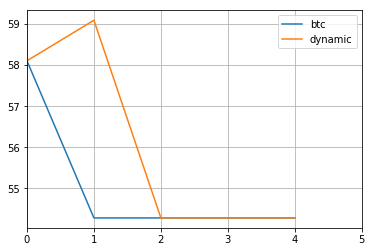

In [14]:
capital = 54.28 # USD
btc_inicial = capital/criptos["BTC"][0][0]
bitcoiner = [btc_inicial*criptos["BTC"][0][1]]
estatico = [bitcoiner[-1]]
dinamico = [bitcoiner[-1]]
dinamico_real = [bitcoiner[-1]]
horizonte = 5 # dias a considerar
anterior = "BTC"
aux = dws_f_obj.items()
aux.sort()
for t,_ in aux[:horizonte]:
    if t > 0:
        dinamico_real.append((((dinamico_real[-1]/criptos[anterior][t-1][1])*criptos[anterior][t][0])/criptos[elegida][t][0])*criptos[elegida][t][1])
        if t == 1:
            bitcoiner.append(capital)
            estatico.append((((estatico[-1]/criptos[anterior][t-1][1])*criptos[anterior][t][0])/criptos[fijo][t][0])*criptos[fijo][t][1])
            dinamico.append((((dinamico[-1]/criptos[anterior][t-1][1])*criptos[anterior][t][0])/criptos[elegida][t][0])*criptos[elegida][t][1])
        else:
            estatico.append((estatico[-1]/criptos[fijo][t-1][1])*criptos[fijo][t][1])
            if t < 168: #if t <= 168: #if t <= t_inversion_inicial
                dinamico.append(capital)
                bitcoiner.append(capital)
            else:
                bitcoiner.append((bitcoiner[-1]/criptos["BTC"][t-1][1])*criptos["BTC"][t][1])
                dinamico.append((dinamico[-1]/criptos[anterior][t-1][1])*criptos[elegida][t][1])
        anterior = elegida
    elegida = dws_f_obj[t].index(max(dws_f_obj[t]))+1
    #print "Dia",t+1,":",elegida,"(",ids[elegida],")"
    if t == 0:
        fijo = ids[elegida]
    elegida = ids[elegida]

tiempos = np.arange(horizonte)
plt.plot(tiempos,bitcoiner)
#plt.plot(tiempos,estatico)
plt.plot(tiempos,dinamico)
plt.legend(["btc","dynamic"])
axes = plt.gca()
axes.set_xlim([0,horizonte])
plt.grid(True)
#plt.savefig('investingfor'+str(horizonte)+'days.eps')

#f, ax = plt.subplots(2, sharex = True)
#axes = plt.gca()
#plt.xlabel("Day")
#plt.ylabel("Dollars")
#ax[0].plot(tiempos,bitcoiner)
#ax[0].plot(tiempos,dinamico)
#ax[0].legend(["btc","dynamic"])
#ax[1].plot(tiempos,bitcoiner2)
#ax[1].plot(tiempos,dinamico2)
#ax[1].legend(["btc","dynamic"])
#ax[0].grid(True)
#ax[1].grid(True)
plt.show()
#f.savefig('investingtolerance.eps')
#plt.show()

In [ ]:
buscados = ["BTC", "BCH", "XRP", "ETH", "ADA"]
idsbuscados = {}
ranking = {"BTC":[],"BCH":[],"XRP":[],"ETH":[],"ADA":[]}
for numero in ids:
    if ids[numero] in buscados:
        idsbuscados[ids[numero]] = numero
for moneda in idsbuscados:
    for dia in dws_f_obj:
        rr = list(dws_f_obj[dia])
        rr.sort()
        rr.reverse()
        r = dws_f_obj[dia][idsbuscados[moneda]-1]
        ranking[moneda].append(rr.index(r)+1)
horizonte = 120
tiempos = np.arange(1,horizonte+1)
plt.plot(tiempos,ranking["BTC"][:horizonte])
#plt.plot(tiempos,ranking["BCH"][:horizonte])
#plt.plot(tiempos,ranking["XRP"][:horizonte])
plt.plot(tiempos,ranking["ETH"][:horizonte])
plt.legend(["BTC","ETH"])
plt.ylabel("Ranking")
plt.xlabel("Day")
plt.grid(True)
plt.savefig('ranking.eps')
plt.show()

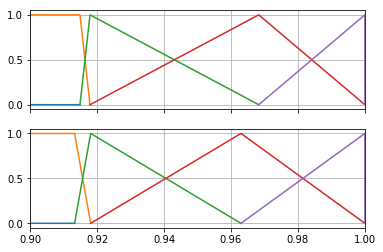

[[-28.2022, -28.2022, 0.9149], [-28.2022, 0.9149, 0.9179], [0.9149, 0.9179, 0.9683], [0.9179, 0.9683, 1.0], [0.9683, 1.0, 1.0]]
[[-28.3676, -28.3676, 0.9133], [-28.3676, 0.9133, 0.9181], [0.9133, 0.9181, 0.963], [0.9181, 0.963, 1.0], [0.963, 1.0, 1.0]]


In [24]:
y = [0,1,0]
atributo = 3
f, ax = plt.subplots(2, sharex = True)
axes = plt.gca()
axes.set_xlim([0.9,1])
for i in range(linguistic_var_number):
    ax[0].plot(LV_time[0][atributo][i],[0,1,0])
    ax[1].plot(LV_time[4][atributo][i],[0,1,0])
ax[0].grid(True)
ax[1].grid(True)
plt.show()
f.savefig('a'+str(atributo+1)+'mf_zoom.eps')
#plt.figure()
#for i in range(linguistic_var_number):
#    plt.plot(LV_time[4][atributo][i],[0,1,0])
#plt.show()

print LV_time[0][atributo]
print LV_time[4][atributo]
#print LV_time[2][atributo]

In [15]:
all_data

{0: [[0.899850446083, 1.18668088997, 21.11773740357971, 24.3233468637015],
  [0.925943790597, 1.14533162082, 19.674808494993922, 23.055118427621025],
  [0.909046794039, 1.14650968435, 19.614385006801502, 22.980951885535834],
  [0.93417213787, 1.11317360446, 21.72468417262309, 25.11846286004368],
  [1.15181289787, 1.85697821828, 17.728906620318178, -708.3964185322641]],
 1: [[0.850315443782, 1.24001571765, 21.311990950256934, 24.212901355070443],
  [0.850360043402, 1.21469795307, 19.61143760109963, 23.033044990520697],
  [0.895913559255, 1.16748826291, 19.294535679828865, 22.894869426440838],
  [0.922615715988, 1.11761999805, 21.817645848819268, 25.053413479429476],
  [1.15181289787, 1.85697821828, 17.728906620318178, -708.3964185322641]],
 2: [[1.06545570427, 1.06753006475, 20.7804303618788, 24.11236027254082],
  [1.1790201005, 1.19025483369, 20.356886817545448, 22.916560479974546],
  [1.05226772613, 1.05612066758, 18.9110811866758, 22.832516149623],
  [1.05038854451, 1.05498801578, 21